#Team 12 composition:
Alessandro Paolillo 0622701812

Thomas Landi 0622701813

Marco Savarese 0622701847

Francesco Santorelli 0622701809

#Connect to Google Drive
Mount Google Drive into Colaboratory,
then move the work directory to the Google Drive directory where you copied the dataset file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import os
os.chdir('/content/drive/MyDrive/12')  # edit this path to match that of your Google Drive directory
model_dir = '/content/drive/MyDrive/12/'
import keras
print('Keras version:', keras.__version__)

from keras import backend as K
print('List of available GPUs:', K._get_available_gpus()) 

Mounted at /content/drive
Keras version: 2.8.0
List of available GPUs: ['/device:GPU:0']


In [ ]:
import gdown
import PIL.Image
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, save_model, load_model
from keras.layers import Activation, Dropout, Dense, Flatten
from keras import applications
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
from tensorflow.keras.applications import Xception
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
import seaborn as sns

#Dataset

#Before to start
Manually copy the dataset file `'dataset.zip'` in a directory in your Google Drive and move to that directory

In [ ]:
url = 'https://drive.google.com/uc?id=1A5vhV7FkiqzqhUkYitEs-sTucHAN-jY-'
gdown.download(url, 'datasetNew.zip', quiet=False)

! unzip -q -n datasetNew.zip
! echo 'Training folder content'
! ls -l ./datasetNew/train/
! echo 'Validation folder content'
! ls -l ./datasetNew/validation/

Downloading...
From: https://drive.google.com/uc?id=1A5vhV7FkiqzqhUkYitEs-sTucHAN-jY-
To: /content/drive/MyDrive/12/datasetNew.zip
100%|██████████| 754M/754M [00:03<00:00, 223MB/s]


Training folder content
total 12
drwx------ 2 root root 4096 Jul 12 21:03 Caravaggio
drwx------ 2 root root 4096 Jul 12 22:32 Manet
drwx------ 2 root root 4096 Jul 12 21:16 VanGogh
Validation folder content
total 12
drwx------ 2 root root 4096 Jul 12 21:16 Caravaggio
drwx------ 2 root root 4096 Jul 12 22:33 Manet
drwx------ 2 root root 4096 Jul 12 21:16 VanGogh


In [ ]:
# set the paths
train_data_dir = 'datasetNew/train/'
val_data_dir = 'datasetNew/validation/'
# training parameters
nb_train_samples = 3900
nb_val_samples = 540

Import the needed python modules.
Add here all the python module you need to complete the homework.

##Preprocessing data

In [ ]:
xception_custom = load_model('final_model')
print('All loaded')

All loaded


In [ ]:
num_classes = 3                   #number of classes
tick_labels = ['Caravaggio', 'Edouard Manet','Vincent_Van_Gogh']

In [ ]:
### DATA GENERATOR
# get data from the folder, perform the preprocessing and the data augmentation,
# and arranges them in batches

# this is the preprocessing configuration we will use for validation:
# rescaling only
val_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
img_width, img_height = 256, 256  # resize dimensions of our images #256 256
batch_size = 32                   # number of images in a batch

print('Validation set generator:')
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),  # resize the image in order to match the network input size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')       

Validation set generator:
Found 540 images belonging to 3 classes.


In [ ]:
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

#Build a text report showing the main classification metrics.

In [ ]:
def showClassficationReport_Generator(model, val_generator, STEP_SIZE_VALID, modelName):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(val_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(num_classes,num_classes))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
    cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title("Confusion Matrix " + modelName)
    plt.show()
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(num_classes), target_names=tick_labels))
    return y_true, y_pred

In [ ]:
# Number of errors:
def errorModel(y_true, y_pred,modelName):
  err=np.argwhere(y_true!=y_pred).reshape((-1,))
  print("Errors " + modelName + ": " + str(err.size))

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

##Per-class performance evaluation
We define a function to compute and visualize the confusion matrix.
The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification).

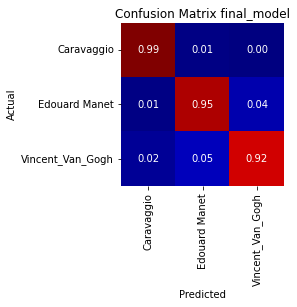

Classification Report:
                  precision    recall  f1-score   support

      Caravaggio       0.97      0.99      0.98       173
   Edouard Manet       0.94      0.95      0.95       170
Vincent_Van_Gogh       0.96      0.92      0.94       169

        accuracy                           0.96       512
       macro avg       0.96      0.96      0.96       512
    weighted avg       0.96      0.96      0.96       512

Errors final_model: 22


In [ ]:
y_true, y_pred = showClassficationReport_Generator(xception_custom, val_generator, STEP_SIZE_VALID, 'final_model')
errorModel(y_true, y_pred, 'final_model')

#Function predict

##Labels one-hot encoding
We convert the y arrays to "one-hot encoding"

In [ ]:
def one_hot(a, n):
    e = np.eye(n) # Identity matrix n x n
    result=e[a.astype(np.uint8)]
    return result

We define a function to print the details of the prediction

In [ ]:
def predict(X):
    tf.keras.backend.cast(X,'float32')
    predictions = xception_custom.predict(X)
    pred = predictions.argmax(1)
    pred_1h = one_hot(pred,X.shape[3])
    return pred_1h

In [ ]:
y_pred = []
y_true = []
for i in range(STEP_SIZE_VALID):
        (X,y) = next(val_generator)
        #y_pred.append(predict(X))
        #y_true.append(y)
        print(predict(X))
 

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [